# Task 2: RNN application -- Tweet Sentiment Analysis

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### Load data

In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1: LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis. The network structure is the following:

![](./img/singleLSTM.png)

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

In [3]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b

In [4]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [5]:
# Training function
num_steps = train_tweets.shape[0]//batch_size
mean_loss = 0
train_total = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start = step*batch_size 
        end = start + batch_size

        batch_tweet = train_tweets[start:end]
        batch_label = train_labels[start:end]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict={tweets:batch_tweet,labels:batch_label})
        train_total += train_loss
        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            test_loss = 0
            for i in range(test_batches):
                l = i*batch_size
                r = l + batch_size
                test_X = test_tweets[l:r]
                test_Y = test_labels[l:r]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
                test_loss += sess.run(loss,feed_dict= {tweets:test_X,labels:test_Y})
                mean_loss = train_total/(step+1)
            print("step: ",step," Accuracy = ",(test_acc/test_batches), " Mean Loss = ", mean_loss)
            

step:  0  Accuracy =  0.541666666667  Mean Loss =  0.692701220512
step:  50  Accuracy =  0.627083333333  Mean Loss =  0.681698779265
step:  100  Accuracy =  0.677083333333  Mean Loss =  0.642125983049
step:  150  Accuracy =  0.696875  Mean Loss =  0.615378264362
step:  200  Accuracy =  0.709375  Mean Loss =  0.59999434435
step:  250  Accuracy =  0.719791666667  Mean Loss =  0.589441313449
step:  300  Accuracy =  0.725  Mean Loss =  0.582960283142
step:  350  Accuracy =  0.702083333333  Mean Loss =  0.575377507682
step:  400  Accuracy =  0.7375  Mean Loss =  0.567339816667
step:  450  Accuracy =  0.739583333333  Mean Loss =  0.563497719109
step:  500  Accuracy =  0.736458333333  Mean Loss =  0.559812697465
step:  550  Accuracy =  0.7375  Mean Loss =  0.556642694017
step:  600  Accuracy =  0.711458333333  Mean Loss =  0.553126814411
step:  650  Accuracy =  0.75  Mean Loss =  0.548556386738
step:  700  Accuracy =  0.757291666667  Mean Loss =  0.545825862553
step:  750  Accuracy =  0.74791

### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.

![](./img/doubleLSTM.png)

In [6]:
# YOUR DOUBLE-LAYER LSTM Here
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
num_layers = 2

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
# lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)
lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(hidden_size) for i in range(num_layers)])

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1][-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)


In [7]:
# YOUR TRAINING HERE
num_steps = train_tweets.shape[0]//batch_size
mean_loss = 0
train_total = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start = step*batch_size
        end = start + batch_size
                
        batch_tweet = train_tweets[start:end]
        batch_label = train_labels[start:end]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict={tweets:batch_tweet,labels:batch_label})
        train_total += train_loss
        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            for i in range(test_batches):
                l = i*batch_size
                r = l + batch_size
                test_X = test_tweets[l:r]
                test_Y = test_labels[l:r]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
                test_loss += sess.run(loss,feed_dict= {tweets:test_X,labels:test_Y})
                mean_loss = train_total/(step+1)
            print("step: ",step," Accuracy = ",(test_acc/test_batches), " Mean Loss = ", mean_loss)
            

step:  0  Accuracy =  0.557291666667  Mean Loss =  0.69356328249
step:  50  Accuracy =  0.660416666667  Mean Loss =  0.663909698234
step:  100  Accuracy =  0.679166666667  Mean Loss =  0.628872762222
step:  150  Accuracy =  0.709375  Mean Loss =  0.604339958816
step:  200  Accuracy =  0.717708333333  Mean Loss =  0.590522054268
step:  250  Accuracy =  0.740625  Mean Loss =  0.581135162794
step:  300  Accuracy =  0.748958333333  Mean Loss =  0.575728826547
step:  350  Accuracy =  0.726041666667  Mean Loss =  0.568300984948
step:  400  Accuracy =  0.753125  Mean Loss =  0.560448110029
step:  450  Accuracy =  0.741666666667  Mean Loss =  0.55604245849
step:  500  Accuracy =  0.747916666667  Mean Loss =  0.552745302042
step:  550  Accuracy =  0.755208333333  Mean Loss =  0.549964448447
step:  600  Accuracy =  0.734375  Mean Loss =  0.54697419279
step:  650  Accuracy =  0.757291666667  Mean Loss =  0.542550471063
step:  700  Accuracy =  0.766666666667  Mean Loss =  0.539897712338
step:  750

## Part 2: Embedding Lookup layer

![](./img/embedding.png)

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

[https://www.tensorflow.org/tutorials/word2vec](https://www.tensorflow.org/tutorials/word2vec)

In [21]:
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
    embedding_mat = tf.Variable(tf.random_uniform([vocab_size, output_size], -1.0, 1.0),name = name)
    embed_lookup = tf.nn.embedding_lookup(embedding_mat, input_)
    return embedding_mat,embed_lookup

### Train a single lstm network with embedding layer

In [22]:
# YOUR EMBEDDING SINGLE-LAYER LSTM HERE
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
output_size = 150


# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

embedding_mat, lookup = embedding(tweets,vocab_size,output_size,'embedding_mat')

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, lookup, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [23]:
# YOUR TRAINING HERE
num_steps = train_tweets.shape[0] // batch_size
mean_loss = 0
train_total = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start_idx = step*batch_size
        end_idx = start_idx + batch_size
        

        batchX = train_tweets[start_idx:end_idx]
        batchY = train_labels[start_idx:end_idx]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict= \
                                                {tweets:batchX,labels:batchY})
        train_total += train_loss
        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            for i in range(test_batches):
                idx1 = i*batch_size
                idx2 = idx1 + batch_size
                test_X = test_tweets[idx1:idx2]
                test_Y = test_labels[idx1:idx2]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
                
            mean_loss = train_total/(step+1)
            print("step: ",step," Accuracy = ",(test_acc/test_batches), " Mean Loss = ", mean_loss)
            # TODO: get test accuracy and loss, and print them out.
    vocab_embeddings = sess.run(embedding_mat)

step:  0  Accuracy =  0.534375  Mean Loss =  0.698773264885
step:  50  Accuracy =  0.553125  Mean Loss =  0.693176641184
step:  100  Accuracy =  0.584375  Mean Loss =  0.688724697816
step:  150  Accuracy =  0.641666666667  Mean Loss =  0.674904002654
step:  200  Accuracy =  0.675  Mean Loss =  0.659717993357
step:  250  Accuracy =  0.708333333333  Mean Loss =  0.645617225731
step:  300  Accuracy =  0.708333333333  Mean Loss =  0.639122467401
step:  350  Accuracy =  0.698958333333  Mean Loss =  0.628749201355
step:  400  Accuracy =  0.698958333333  Mean Loss =  0.619741013
step:  450  Accuracy =  0.723958333333  Mean Loss =  0.612193536534
step:  500  Accuracy =  0.730208333333  Mean Loss =  0.606019022282
step:  550  Accuracy =  0.751041666667  Mean Loss =  0.600268600857
step:  600  Accuracy =  0.75  Mean Loss =  0.594674198679
step:  650  Accuracy =  0.75  Mean Loss =  0.588545608401
step:  700  Accuracy =  0.752083333333  Mean Loss =  0.583799130821
step:  750  Accuracy =  0.740625 

### Visualize word vectors via tSNE

First, you need to retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, you should visualize some interesting word pairs in 2D panel. You may find **scatter** function in **matplotlib.pyplot** useful.


You can use **TSNE** tool provided in **scikit-learn**.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.


![](./img/tsne_female_male.png)

In [24]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
#fruit_clour = ["apple", "red", "lemon", "yellow", "mandarin", "orange"]

vocab_embeddings.shape

(7597, 150)

In [25]:
from sklearn.manifold import TSNE
### your code here
X_embedded = TSNE( n_components=2, init='pca', n_iter=1000, random_state=10).fit_transform(vocab_embeddings)
X_embedded.shape

(7597, 2)

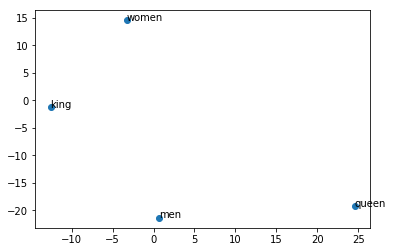

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def wordvec(vocab,words):
    idx = [np.where(vocab==a) for a in words]
    res = []
    for i in range(len(idx)):
        res.append(idx[i][0][0])
    return res
X = X_embedded[wordvec(vocabulary,female_male)]

plt.scatter(X[:,0],X[:,1])

for i, txt in enumerate(female_male):
    plt.annotate(txt, (X[i,0],X[i,1]))
plt.show()



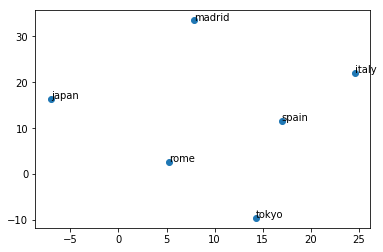

In [27]:
X = X_embedded[wordvec(vocabulary,country_capital)]

plt.scatter(X[:,0],X[:,1])

for i, txt in enumerate(country_capital):
    plt.annotate(txt, (X[i,0],X[i,1]))
plt.show()

Describe your observation of these word vectors

Answer: **We see in the above two example that the vectors joining men-king and women-queen seem to be parallel as expected based on theory. This however is also true in the second case. The vectors joining japan-rome and madrid-spain are almost parallel and italy-rome is randomly oriented **